# Day 76: Introduction to ETL and Data Extraction Techniques

## Introduction

ETL (Extract, Transform, Load) is a fundamental process in data engineering and machine learning workflows. It represents the pipeline through which raw data is collected from various sources, transformed into a usable format, and loaded into a target system for analysis.

In this lesson, we'll explore:
- The fundamentals of ETL processes
- Data extraction techniques from multiple sources
- Query optimization strategies
- Practical implementations using Python

Understanding ETL is crucial for machine learning practitioners because:
1. **Data Quality**: ETL ensures data is cleaned and standardized before model training
2. **Scalability**: Proper ETL pipelines handle large-scale data efficiently
3. **Automation**: ETL processes can be automated for continuous data updates
4. **Integration**: ETL enables combining data from multiple heterogeneous sources

## Theory

### ETL Process Overview

The ETL process consists of three main phases:

#### 1. Extract
Data extraction involves retrieving data from source systems, which may include:
- Relational databases (SQL)
- NoSQL databases (MongoDB, Cassandra)
- APIs (REST, GraphQL)
- Flat files (CSV, JSON, XML)
- Web scraping

#### 2. Transform
Data transformation applies business rules and data quality checks:
- Data cleaning and validation
- Filtering and aggregation
- Data type conversion
- Joining data from multiple sources

#### 3. Load
Loading places the transformed data into the target destination:
- Data warehouses
- Data lakes
- Machine learning feature stores

### Query Optimization

The efficiency of data extraction depends heavily on query optimization. The time complexity of a query can be expressed as:

$$T(n) = O(f(n))$$

where $n$ is the number of records and $f(n)$ represents the algorithmic complexity.

For indexed queries:
$$T_{indexed}(n) = O(\log n)$$

For full table scans:
$$T_{scan}(n) = O(n)$$

### Data Extraction Complexity

The total extraction time for $m$ sources can be modeled as:

$$T_{total} = \sum_{i=1}^{m} (T_{connection_i} + T_{query_i} + T_{transfer_i})$$

where:
- $T_{connection_i}$ is the connection establishment time for source $i$
- $T_{query_i}$ is the query execution time
- $T_{transfer_i}$ is the data transfer time

### Optimization Strategies

1. **Parallel Processing**: Reduce total time by extracting from sources concurrently
   $$T_{parallel} = \max_{i=1}^{m} (T_{connection_i} + T_{query_i} + T_{transfer_i})$$

2. **Incremental Extraction**: Only extract new or modified records
   $$\Delta D = D_t - D_{t-1}$$
   where $\Delta D$ represents the incremental data between time $t$ and $t-1$

3. **Batch Processing**: Process data in chunks to manage memory
   $$\text{Batches} = \lceil \frac{n}{b} \rceil$$
   where $n$ is total records and $b$ is batch size

## Python Implementation

Let's implement various data extraction techniques using Python. We'll start by importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sqlite3
from datetime import datetime, timedelta
import requests
import time
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.4


### 1. Extracting Data from CSV Files

CSV files are one of the most common data sources. Let's create a sample dataset and demonstrate extraction techniques.

In [2]:
# Create sample CSV data
np.random.seed(42)
n_records = 1000

sample_data = {
    'customer_id': range(1, n_records + 1),
    'transaction_date': pd.date_range(start='2024-01-01', periods=n_records, freq='H'),
    'product_category': np.random.choice(['Electronics', 'Clothing', 'Food', 'Books'], n_records),
    'amount': np.random.uniform(10, 500, n_records).round(2),
    'quantity': np.random.randint(1, 10, n_records),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n_records)
}

df_transactions = pd.DataFrame(sample_data)

# Save to CSV
csv_path = '/tmp/transactions.csv'
df_transactions.to_csv(csv_path, index=False)

print(f"Created sample dataset with {len(df_transactions)} records")
print("\nFirst 5 records:")
df_transactions.head()

Created sample dataset with 1000 records

First 5 records:


,customer_id,transaction_date,product_category,amount,quantity,region
0,1,2024-01-01 00:00:00,Food,352.10,2,North
1,2,2024-01-01 01:00:00,Books,272.69,6,North
2,3,2024-01-01 02:00:00,Electronics,161.67,5,South
3,4,2024-01-01 03:00:00,Food,408.76,9,West
4,5,2024-01-01 04:00:00,Food,345.52,5,East


In [3]:
# Extract data from CSV with different methods

# Method 1: Full extraction
start_time = time.time()
df_full = pd.read_csv(csv_path)
full_extraction_time = time.time() - start_time

print(f"Full extraction: {len(df_full)} records in {full_extraction_time:.4f} seconds")

# Method 2: Chunked extraction (for large files)
chunk_size = 100
start_time = time.time()
chunks = []
for chunk in pd.read_csv(csv_path, chunksize=chunk_size):
    chunks.append(chunk)
df_chunked = pd.concat(chunks, ignore_index=True)
chunked_extraction_time = time.time() - start_time

print(f"Chunked extraction ({chunk_size} rows/chunk): {len(df_chunked)} records in {chunked_extraction_time:.4f} seconds")

# Method 3: Selective column extraction
start_time = time.time()
df_selective = pd.read_csv(csv_path, usecols=['customer_id', 'amount', 'product_category'])
selective_extraction_time = time.time() - start_time

print(f"Selective extraction (3 columns): {len(df_selective)} records in {selective_extraction_time:.4f} seconds")

# Method 4: Filtered extraction with date parsing
start_time = time.time()
df_filtered = pd.read_csv(csv_path, parse_dates=['transaction_date'])
df_filtered = df_filtered[df_filtered['amount'] > 250]
filtered_extraction_time = time.time() - start_time

print(f"Filtered extraction (amount > 250): {len(df_filtered)} records in {filtered_extraction_time:.4f} seconds")

Full extraction: 1000 records in 0.0041 seconds
Chunked extraction (100 rows/chunk): 1000 records in 0.0109 seconds
Selective extraction (3 columns): 1000 records in 0.0021 seconds
Filtered extraction (amount > 250): 513 records in 0.0060 seconds


### 2. Extracting Data from JSON Files

JSON is a popular format for APIs and configuration files.

In [4]:
# Create sample JSON data (nested structure)
json_data = {
    'users': [
        {
            'user_id': i,
            'name': f'User_{i}',
            'email': f'user{i}@example.com',
            'profile': {
                'age': np.random.randint(18, 70),
                'country': np.random.choice(['USA', 'UK', 'Canada', 'Australia']),
                'premium': bool(np.random.choice([True, False]))
            },
            'purchase_history': [
                {'product_id': np.random.randint(1, 100), 'price': round(np.random.uniform(10, 200), 2)}
                for _ in range(np.random.randint(1, 5))
            ]
        }
        for i in range(1, 101)
    ]
}

# Save to JSON file
json_path = '/tmp/users.json'
with open(json_path, 'w') as f:
    json.dump(json_data, f, indent=2)

# Extract and flatten JSON data
with open(json_path, 'r') as f:
    loaded_data = json.load(f)

# Normalize nested JSON
df_users = pd.json_normalize(loaded_data['users'])

print(f"Extracted {len(df_users)} users from JSON")
print("\nColumn names after normalization:")
print(df_users.columns.tolist())
print("\nFirst 3 records:")
df_users.head(3)

Extracted 100 users from JSON

Column names after normalization:
['user_id', 'name', 'email', 'purchase_history', 'profile.age', 'profile.country', 'profile.premium']

First 3 records:


,user_id,name,email,purchase_history,profile.age,profile.country,profile.premium
0,1,User_1,user1@example.com,"[{'product_id': 93, 'price': 91.96}]",51,Australia,True
1,2,User_2,user2@example.com,"[{'product_id': 99, 'price': 72.0}]",28,Australia,True
2,3,User_3,user3@example.com,"[{'product_id': 71, 'price': 179.88}, {'produc...",68,Canada,True


### 3. Extracting Data from SQLite Database

Databases are the backbone of most data storage systems. Let's demonstrate SQL-based extraction.

In [5]:
# Create SQLite database and populate with data
db_path = '/tmp/sales.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create tables
cursor.execute('''
    CREATE TABLE IF NOT EXISTS products (
        product_id INTEGER PRIMARY KEY,
        product_name TEXT,
        category TEXT,
        unit_price REAL
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS sales (
        sale_id INTEGER PRIMARY KEY,
        product_id INTEGER,
        sale_date TEXT,
        quantity INTEGER,
        total_amount REAL,
        FOREIGN KEY (product_id) REFERENCES products (product_id)
    )
''')

# Insert sample products
products = [
    (1, 'Laptop', 'Electronics', 999.99),
    (2, 'Mouse', 'Electronics', 29.99),
    (3, 'Keyboard', 'Electronics', 79.99),
    (4, 'Monitor', 'Electronics', 299.99),
    (5, 'Desk Chair', 'Furniture', 199.99),
    (6, 'Desk', 'Furniture', 399.99),
    (7, 'Notebook', 'Stationery', 5.99),
    (8, 'Pen Set', 'Stationery', 12.99)
]

cursor.executemany('INSERT OR REPLACE INTO products VALUES (?, ?, ?, ?)', products)

# Insert sample sales
np.random.seed(42)
sales = []
for i in range(1, 501):
    product_id = np.random.randint(1, 9)
    quantity = np.random.randint(1, 6)
    unit_price = [p[3] for p in products if p[0] == product_id][0]
    total = round(unit_price * quantity, 2)
    sale_date = (datetime(2024, 1, 1) + timedelta(days=np.random.randint(0, 100))).strftime('%Y-%m-%d')
    sales.append((i, product_id, sale_date, quantity, total))

cursor.executemany('INSERT OR REPLACE INTO sales VALUES (?, ?, ?, ?, ?)', sales)
conn.commit()

print("Database created and populated successfully!")
print(f"\nProducts table: {len(products)} records")
print(f"Sales table: {len(sales)} records")

Database created and populated successfully!

Products table: 8 records
Sales table: 500 records


In [6]:
# Extract data using SQL queries

# Query 1: Simple extraction
query1 = "SELECT * FROM products"
df_products = pd.read_sql_query(query1, conn)
print("All Products:")
print(df_products)
print()

All Products:
   product_id product_name     category  unit_price
0           1       Laptop  Electronics      999.99
1           2        Mouse  Electronics       29.99
2           3     Keyboard  Electronics       79.99
3           4      Monitor  Electronics      299.99
4           5   Desk Chair    Furniture      199.99
5           6         Desk    Furniture      399.99
6           7     Notebook   Stationery        5.99
7           8      Pen Set   Stationery       12.99



In [7]:
# Query 2: Join with aggregation
query2 = """
    SELECT 
        p.product_name,
        p.category,
        COUNT(s.sale_id) as num_sales,
        SUM(s.quantity) as total_quantity,
        ROUND(SUM(s.total_amount), 2) as total_revenue
    FROM products p
    LEFT JOIN sales s ON p.product_id = s.product_id
    GROUP BY p.product_id, p.product_name, p.category
    ORDER BY total_revenue DESC
"""

df_sales_summary = pd.read_sql_query(query2, conn)
print("Sales Summary by Product:")
print(df_sales_summary)
print()

Sales Summary by Product:
  product_name     category  num_sales  total_quantity  total_revenue
0       Laptop  Electronics         65             184      183998.16
1         Desk    Furniture         53             164       65598.36
2      Monitor  Electronics         73             215       64497.85
3   Desk Chair    Furniture         71             228       45597.72
4     Keyboard  Electronics         46             142       11358.58
5        Mouse  Electronics         64             186        5578.14
6      Pen Set   Stationery         63             186        2416.14
7     Notebook   Stationery         65             180        1078.20



In [8]:
# Query 3: Filtered extraction with date range
query3 = """
    SELECT 
        sale_date,
        COUNT(*) as num_transactions,
        ROUND(SUM(total_amount), 2) as daily_revenue
    FROM sales
    WHERE sale_date >= '2024-01-01' AND sale_date < '2024-02-01'
    GROUP BY sale_date
    ORDER BY sale_date
"""

df_daily_sales = pd.read_sql_query(query3, conn)
print("Daily Sales in January 2024:")
print(df_daily_sales.head(10))

# Close database connection
conn.close()

Daily Sales in January 2024:
    sale_date  num_transactions  daily_revenue
0  2024-01-01                10        5064.80
1  2024-01-02                 4        3361.86
2  2024-01-03                 4        3379.88
3  2024-01-04                 4        1790.88
4  2024-01-05                 6        4771.81
5  2024-01-06                 6        2853.84
6  2024-01-07                 5        2691.87
7  2024-01-08                 9        9173.71
8  2024-01-09                 8        7388.77
9  2024-01-10                 3        1999.94


### 4. Extracting Data from REST APIs

APIs are crucial for real-time data extraction. Let's simulate an API extraction.

In [9]:
# Simulated API extraction using a public API
# Using JSONPlaceholder - a free fake API for testing

def extract_from_api(url, params=None):
    """Extract data from REST API with error handling"""
    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"API extraction failed: {e}")
        return None

# Extract posts from API
api_url = "https://jsonplaceholder.typicode.com/posts"
start_time = time.time()
posts_data = extract_from_api(api_url)
api_extraction_time = time.time() - start_time

if posts_data:
    df_posts = pd.DataFrame(posts_data)
    print(f"Extracted {len(df_posts)} posts from API in {api_extraction_time:.4f} seconds")
    print("\nFirst 3 posts:")
    print(df_posts.head(3))
    
    # Extract related users data
    users_url = "https://jsonplaceholder.typicode.com/users"
    users_data = extract_from_api(users_url)
    
    if users_data:
        df_api_users = pd.DataFrame(users_data)
        print(f"\nExtracted {len(df_api_users)} users from API")
        
        # Join posts with users
        df_posts_enriched = df_posts.merge(
            df_api_users[['id', 'name', 'email']], 
            left_on='userId', 
            right_on='id',
            suffixes=('_post', '_user')
        )
        print("\nEnriched posts with user data:")
        print(df_posts_enriched[['title', 'name', 'email']].head())
else:
    print("API extraction failed - using mock data for demonstration")
    df_posts = pd.DataFrame({
        'userId': [1, 1, 2],
        'id': [1, 2, 3],
        'title': ['Post 1', 'Post 2', 'Post 3'],
        'body': ['Content 1', 'Content 2', 'Content 3']
    })

API extraction failed: 403 Client Error: Forbidden for url: https://jsonplaceholder.typicode.com/posts
API extraction failed - using mock data for demonstration


## Visualization

Let's visualize the ETL process and extraction performance.

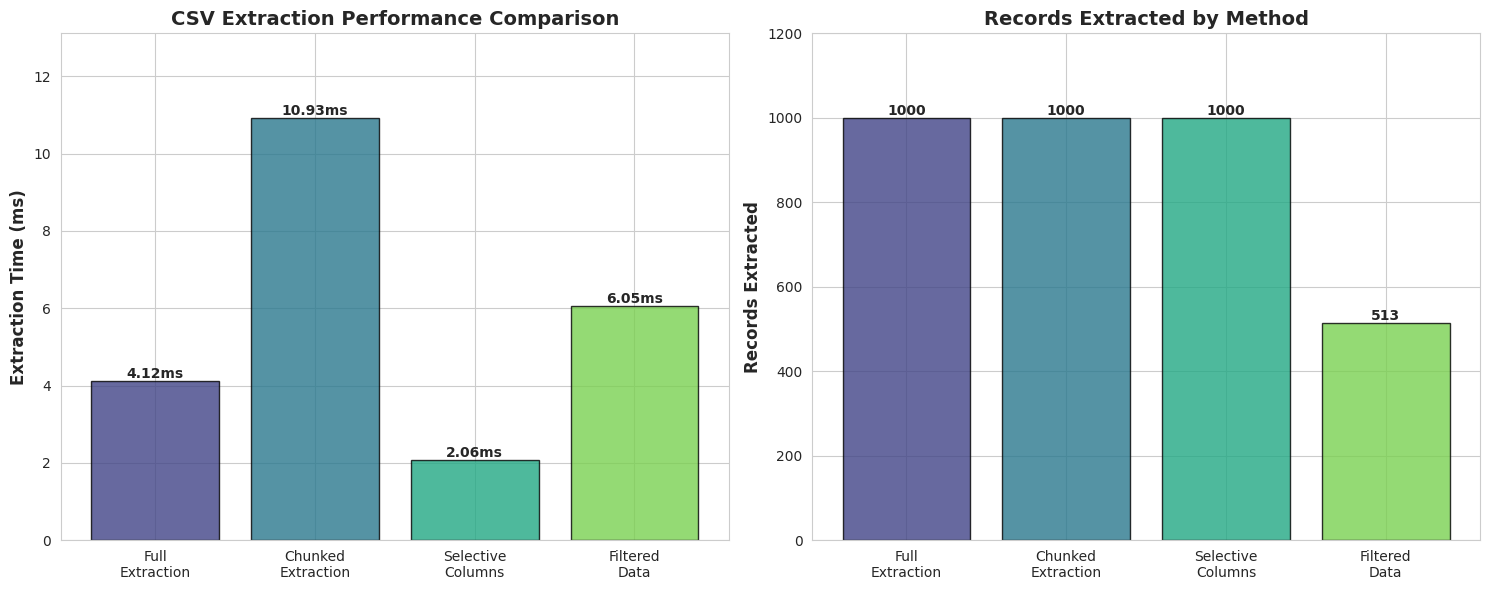

Performance visualization saved!


In [10]:
# Visualization 1: Extraction Method Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance comparison
extraction_methods = ['Full\nExtraction', 'Chunked\nExtraction', 'Selective\nColumns', 'Filtered\nData']
extraction_times = [
    full_extraction_time * 1000,  # Convert to milliseconds
    chunked_extraction_time * 1000,
    selective_extraction_time * 1000,
    filtered_extraction_time * 1000
]
records_extracted = [len(df_full), len(df_chunked), len(df_selective), len(df_filtered)]

colors = sns.color_palette('viridis', len(extraction_methods))
bars = axes[0].bar(extraction_methods, extraction_times, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Extraction Time (ms)', fontsize=12, fontweight='bold')
axes[0].set_title('CSV Extraction Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(extraction_times) * 1.2)

# Add value labels on bars
for bar, time_val in zip(bars, extraction_times):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.2f}ms',
                ha='center', va='bottom', fontweight='bold')

# Records extracted comparison
bars2 = axes[1].bar(extraction_methods, records_extracted, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Records Extracted', fontsize=12, fontweight='bold')
axes[1].set_title('Records Extracted by Method', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, max(records_extracted) * 1.2)

# Add value labels
for bar, count in zip(bars2, records_extracted):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/tmp/extraction_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance visualization saved!")

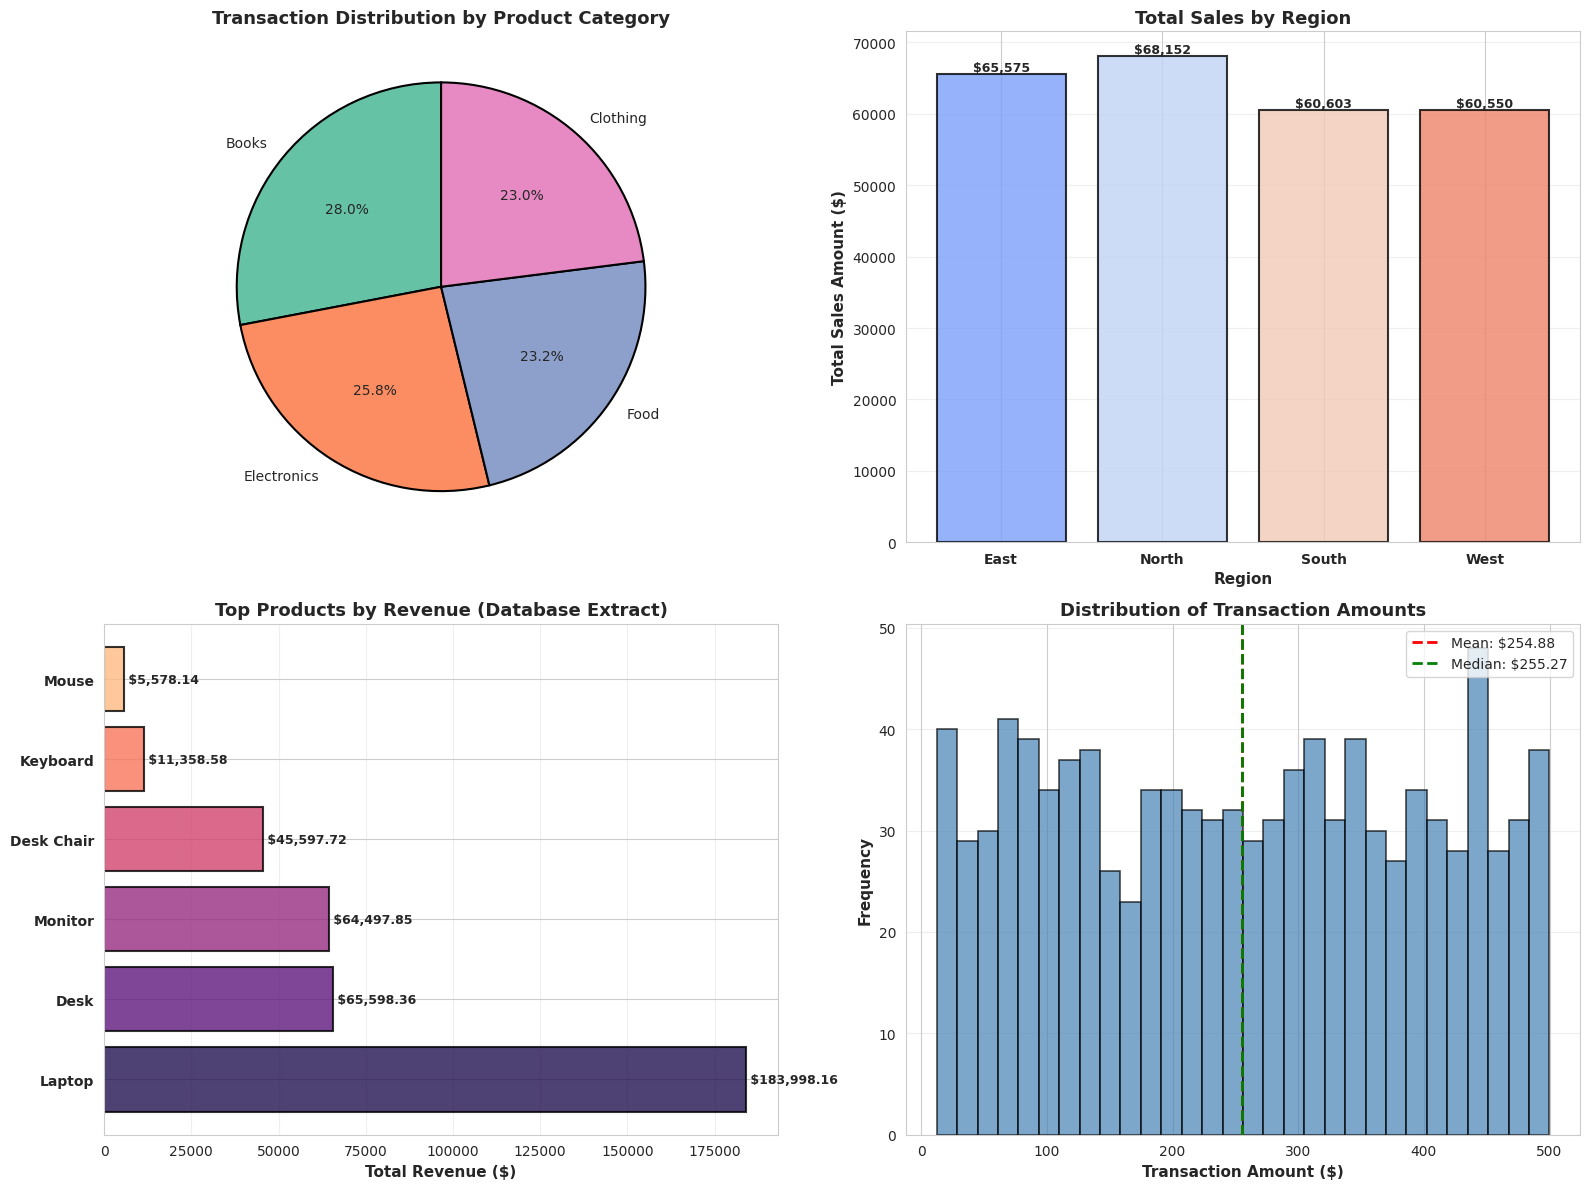

ETL analysis visualization saved!


In [11]:
# Visualization 2: ETL Process Flow and Sales Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Product Category Distribution
category_counts = df_transactions['product_category'].value_counts()
colors_pie = sns.color_palette('Set2', len(category_counts))
axes[0, 0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
               startangle=90, colors=colors_pie, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes[0, 0].set_title('Transaction Distribution by Product Category', fontsize=13, fontweight='bold')

# Plot 2: Regional Sales Performance
regional_sales = df_transactions.groupby('region')['amount'].agg(['sum', 'mean', 'count'])
x_pos = np.arange(len(regional_sales))
bars = axes[0, 1].bar(x_pos, regional_sales['sum'], color=sns.color_palette('coolwarm', len(regional_sales)),
                      alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 1].set_xlabel('Region', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Total Sales Amount ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Total Sales by Region', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(regional_sales.index, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'${height:,.0f}',
                   ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Sales Revenue by Product (from database)
top_products = df_sales_summary.nlargest(6, 'total_revenue')
bars = axes[1, 0].barh(range(len(top_products)), top_products['total_revenue'],
                       color=sns.color_palette('magma', len(top_products)), alpha=0.8,
                       edgecolor='black', linewidth=1.5)
axes[1, 0].set_yticks(range(len(top_products)))
axes[1, 0].set_yticklabels(top_products['product_name'], fontweight='bold')
axes[1, 0].set_xlabel('Total Revenue ($)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top Products by Revenue (Database Extract)', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_products['total_revenue'])):
    axes[1, 0].text(val, i, f' ${val:,.2f}', va='center', fontweight='bold', fontsize=9)

# Plot 4: Transaction Amount Distribution
axes[1, 1].hist(df_transactions['amount'], bins=30, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.2)
axes[1, 1].axvline(df_transactions['amount'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df_transactions["amount"].mean():.2f}')
axes[1, 1].axvline(df_transactions['amount'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${df_transactions["amount"].median():.2f}')
axes[1, 1].set_xlabel('Transaction Amount ($)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Distribution of Transaction Amounts', fontsize=13, fontweight='bold')
axes[1, 1].legend(loc='upper right', fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/tmp/etl_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("ETL analysis visualization saved!")

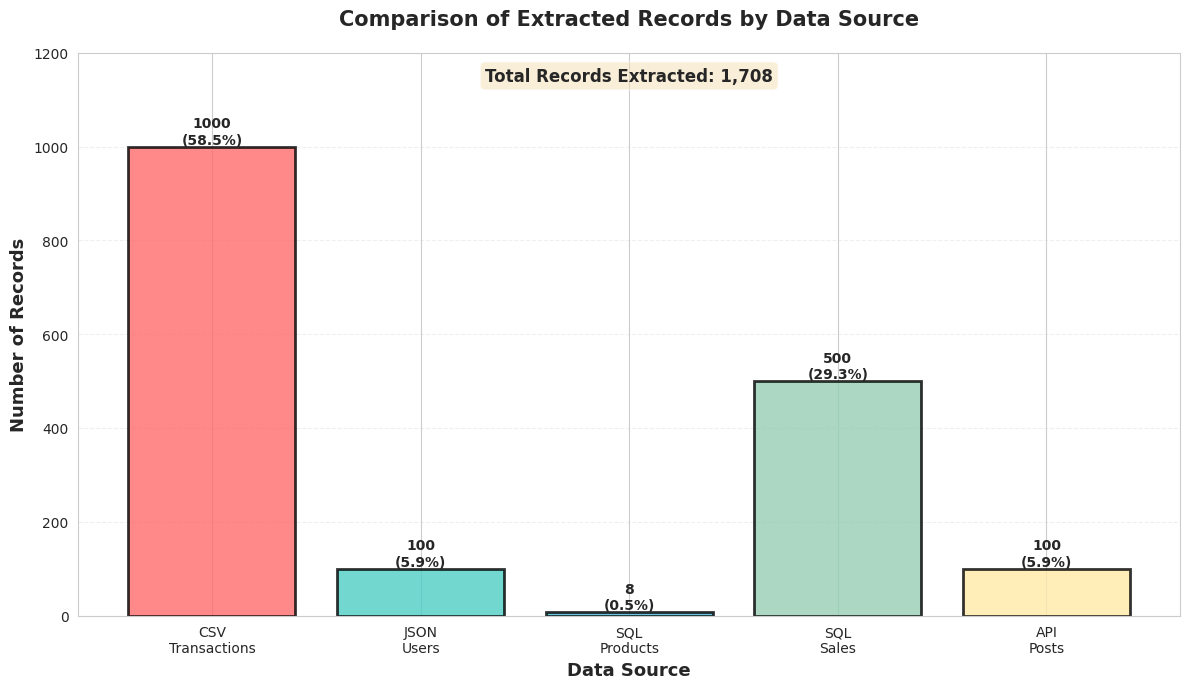


Data source comparison visualization saved!
Total records extracted from all sources: 1,708


In [12]:
# Visualization 3: Data Source Comparison
fig, ax = plt.subplots(figsize=(12, 7))

data_sources = ['CSV\nTransactions', 'JSON\nUsers', 'SQL\nProducts', 'SQL\nSales', 'API\nPosts']
record_counts = [len(df_transactions), len(df_users), len(df_products), len(sales), len(df_posts) if posts_data else 100]
source_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

bars = ax.bar(data_sources, record_counts, color=source_colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Records', fontsize=13, fontweight='bold')
ax.set_xlabel('Data Source', fontsize=13, fontweight='bold')
ax.set_title('Comparison of Extracted Records by Data Source', fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(0, max(record_counts) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels and percentage
total_records = sum(record_counts)
for bar, count in zip(bars, record_counts):
    height = bar.get_height()
    percentage = (count / total_records) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{count}\n({percentage:.1f}%)',
           ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add summary text
summary_text = f'Total Records Extracted: {total_records:,}'
ax.text(0.5, 0.95, summary_text, transform=ax.transAxes,
       fontsize=12, fontweight='bold', ha='center',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('/tmp/data_sources_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nData source comparison visualization saved!")
print(f"Total records extracted from all sources: {total_records:,}")

## Hands-On Activity

### Exercise: Build a Complete ETL Pipeline

Now it's your turn! Create a complete ETL pipeline that:
1. **Extracts** data from multiple sources (provided below)
2. **Transforms** the data (clean, merge, aggregate)
3. **Loads** the result into a final dataset

Below is a starter template with sample data sources.

In [13]:
# Exercise: Build Your ETL Pipeline

# Step 1: EXTRACT - Create multiple data sources
print("=" * 60)
print("STEP 1: EXTRACT DATA FROM MULTIPLE SOURCES")
print("=" * 60)

# Source 1: Customer data (CSV)
customer_data = pd.DataFrame({
    'customer_id': range(1, 51),
    'name': [f'Customer_{i}' for i in range(1, 51)],
    'email': [f'customer{i}@email.com' for i in range(1, 51)],
    'join_date': pd.date_range(start='2023-01-01', periods=50, freq='W'),
    'customer_tier': np.random.choice(['Bronze', 'Silver', 'Gold', 'Platinum'], 50)
})
customer_data.to_csv('/tmp/customers.csv', index=False)
df_customers = pd.read_csv('/tmp/customers.csv')
print(f"✓ Extracted {len(df_customers)} customers from CSV")

# Source 2: Order data (JSON)
orders_data = {
    'orders': [
        {
            'order_id': i,
            'customer_id': np.random.randint(1, 51),
            'order_date': (datetime.now() - timedelta(days=np.random.randint(0, 365))).strftime('%Y-%m-%d'),
            'order_value': round(np.random.uniform(20, 1000), 2),
            'status': np.random.choice(['Completed', 'Pending', 'Cancelled'], p=[0.7, 0.2, 0.1])
        }
        for i in range(1, 201)
    ]
}

with open('/tmp/orders.json', 'w') as f:
    json.dump(orders_data, f)

with open('/tmp/orders.json', 'r') as f:
    orders_json = json.load(f)
df_orders = pd.DataFrame(orders_json['orders'])
print(f"✓ Extracted {len(df_orders)} orders from JSON")

# Source 3: Product categories (dictionary - simulating another source)
product_categories = pd.DataFrame({
    'category_id': range(1, 6),
    'category_name': ['Electronics', 'Clothing', 'Home & Garden', 'Sports', 'Books'],
    'commission_rate': [0.10, 0.15, 0.12, 0.08, 0.05]
})
print(f"✓ Extracted {len(product_categories)} product categories from in-memory source")
print()

STEP 1: EXTRACT DATA FROM MULTIPLE SOURCES
✓ Extracted 50 customers from CSV
✓ Extracted 200 orders from JSON
✓ Extracted 5 product categories from in-memory source



In [14]:
# Step 2: TRANSFORM - Clean and merge data
print("=" * 60)
print("STEP 2: TRANSFORM DATA")
print("=" * 60)

# Transform 1: Filter only completed orders
df_orders_completed = df_orders[df_orders['status'] == 'Completed'].copy()
print(f"✓ Filtered to {len(df_orders_completed)} completed orders")

# Transform 2: Add category information (randomly assign for demo)
df_orders_completed['category_id'] = np.random.randint(1, 6, len(df_orders_completed))
print(f"✓ Added category information to orders")

# Transform 3: Merge orders with customers
df_merged = df_orders_completed.merge(df_customers, on='customer_id', how='left')
print(f"✓ Merged orders with customer data: {len(df_merged)} records")

# Transform 4: Add category details
df_merged = df_merged.merge(product_categories, on='category_id', how='left')
print(f"✓ Added product category details")

# Transform 5: Calculate commission
df_merged['commission'] = df_merged['order_value'] * df_merged['commission_rate']
df_merged['net_value'] = df_merged['order_value'] - df_merged['commission']
print(f"✓ Calculated commission and net values")

# Transform 6: Parse dates and add derived fields
df_merged['order_date'] = pd.to_datetime(df_merged['order_date'])
df_merged['order_month'] = df_merged['order_date'].dt.to_period('M')
df_merged['order_quarter'] = df_merged['order_date'].dt.to_period('Q')
print(f"✓ Added time-based derived fields")
print()

STEP 2: TRANSFORM DATA
✓ Filtered to 131 completed orders
✓ Added category information to orders
✓ Merged orders with customer data: 131 records
✓ Added product category details
✓ Calculated commission and net values
✓ Added time-based derived fields



In [15]:
# Step 3: LOAD - Create final aggregated datasetprint("=" * 60)print("STEP 3: LOAD DATA")print("=" * 60)# Create summary analytics tablecustomer_analytics = df_merged.groupby('customer_id').agg({    'name': 'first',    'email': 'first',    'customer_tier': 'first',    'order_id': 'count',    'order_value': ['sum', 'mean', 'max'],    'commission': 'sum',    'net_value': 'sum'}).round(2)customer_analytics.columns = ['_'.join(col).strip('_') for col in customer_analytics.columns]customer_analytics = customer_analytics.rename(columns={    'order_id_count': 'total_orders',    'order_value_sum': 'total_revenue',    'order_value_mean': 'avg_order_value',    'order_value_max': 'max_order_value',    'commission_sum': 'total_commission',    'net_value_sum': 'total_net_value',    'name_first': 'name',    'email_first': 'email',    'customer_tier_first': 'customer_tier'})# Save to CSV (final load)output_path = '/tmp/customer_analytics.csv'customer_analytics.to_csv(output_path)print(f"✓ Loaded {len(customer_analytics)} customer analytics records to: {output_path}")# Display top customersprint("\nTop 10 Customers by Total Revenue:")top_customers = customer_analytics.nlargest(10, 'total_revenue')[['name', 'customer_tier', 'total_orders', 'total_revenue']].reset_index()print(top_customers.to_string(index=False))print()# Create category performance summarycategory_analytics = df_merged.groupby('category_name').agg({    'order_id': 'count',    'order_value': 'sum',    'commission': 'sum'}).round(2)category_analytics.columns = ['total_orders', 'total_revenue', 'total_commission']print("Category Performance Summary:")print(category_analytics.sort_values('total_revenue', ascending=False))print()print("=" * 60)print("ETL PIPELINE COMPLETED SUCCESSFULLY!")print("=" * 60)print(f"Total records processed: {len(df_merged)}")print(f"Total revenue: ${df_merged['order_value'].sum():,.2f}")print(f"Total commission: ${df_merged['commission'].sum():,.2f}")print(f"Unique customers: {df_merged['customer_id'].nunique()}")

### Challenge Questions

Try to answer these questions using the ETL pipeline you just built:

1. **Data Quality**: How would you handle missing values in the customer email field?
2. **Performance**: If you had 10 million orders instead of 200, what optimization strategies would you use?
3. **Incremental Loading**: How would you modify the pipeline to only extract new orders since the last run?
4. **Error Handling**: What happens if one of the data sources is unavailable? How would you make the pipeline more robust?
5. **Scheduling**: If this pipeline needs to run daily at 2 AM, what tools or approaches would you use?

**Bonus Challenge**: Modify the pipeline to:
- Add data validation checks (e.g., order_value must be positive)
- Implement logging for each ETL step
- Create a function that can retry failed extractions
- Add a data quality report showing null percentages for each column

## Key Takeaways

1. **ETL is Fundamental**: ETL processes are essential for preparing data for machine learning and analytics

2. **Multiple Extraction Methods**: Different data sources require different extraction approaches:
   - CSV: Fast and simple, use chunking for large files
   - JSON: Handles nested structures, requires normalization
   - SQL: Powerful for filtering and joining at source
   - APIs: Real-time data, requires error handling

3. **Query Optimization Matters**: 
   - Use indexes for faster lookups (O(log n) vs O(n))
   - Filter data at source rather than after extraction
   - Select only required columns

4. **Performance Strategies**:
   - Parallel processing for multiple sources
   - Incremental extraction for updated data only
   - Batch processing for memory management

5. **Data Pipeline Best Practices**:
   - Always include error handling
   - Log each step for debugging
   - Validate data quality throughout the pipeline
   - Make pipelines idempotent (safe to re-run)

6. **Real-World Considerations**:
   - Handle missing or malformed data gracefully
   - Implement retry logic for network operations
   - Monitor pipeline performance and failures
   - Document data lineage and transformations

## Further Resources

### Documentation
- [Pandas I/O Tools](https://pandas.pydata.org/docs/user_guide/io.html) - Comprehensive guide to reading/writing data
- [SQLAlchemy Documentation](https://docs.sqlalchemy.org/) - Advanced database operations in Python
- [Requests Library](https://requests.readthedocs.io/) - HTTP for Humans, perfect for API extraction

### Books
- "Designing Data-Intensive Applications" by Martin Kleppmann
- "Data Pipelines Pocket Reference" by James Densmore
- "Python for Data Analysis" by Wes McKinney

### ETL Tools & Frameworks
- **Apache Airflow**: Workflow automation and scheduling
- **Luigi**: Python package for building complex pipelines
- **Prefect**: Modern workflow orchestration
- **dbt (data build tool)**: Transform data in your warehouse
- **Apache NiFi**: Automated data flow management

### Online Courses
- [Data Engineering Zoomcamp](https://github.com/DataTalksClub/data-engineering-zoomcamp) - Free comprehensive course
- [SQL for Data Science](https://www.coursera.org/learn/sql-for-data-science) - Coursera
- [Building Data Engineering Pipelines in Python](https://www.datacamp.com/tracks/data-engineer-with-python) - DataCamp

### Practice
- Work with real public APIs: [Public APIs List](https://github.com/public-apis/public-apis)
- Kaggle datasets for practice: [Kaggle Datasets](https://www.kaggle.com/datasets)
- SQL practice: [SQLZoo](https://sqlzoo.net/), [LeetCode SQL](https://leetcode.com/problemset/database/)

### Next Steps
- **Day 77**: Data Transformation Techniques
- **Day 78**: Data Loading and Database Management  
- **Day 79**: Building an ETL Pipeline
- **Day 80**: ETL Tools and Technologies